# Inspect single neuron model filters

This notebook visualizes the membrane ($\kappa$), spike-triggered current ($\eta$), and spike-triggered threshold movement ($\gamma$) filters of GIF-type models fitted to 5-HT neurons. `5HT_heated` data was recorded at 29C to 30C by Michael Lynn in winter/spring 2022.

In [1]:
from common import colors, insetlw, savefig

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from ezephys import pltools

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'publication_figure_style.dms'))

In [5]:
models = {}
for celltype in ['5HT', '5HT_heated']:
    models[celltype] = {}
    for modtype in ['GIFs', 'AugmentedGIFs', 'iGIF_NPs']:
        with open(
            os.path.join(
                os.getenv('DATA_PATH'),
                'models',
                celltype,
                '5HT_{}'.format(modtype) + '.lmod',
            ),
            'rb',
        ) as f:
            models[celltype][modtype] = pickle.load(f)
            f.close()

# Publication figures

In [6]:
xlims = (0.8, 700)
ylims = {
    'membrane': (-2, 35),
    'eta': (-0.205, 0.7)
}

In [7]:
def nonparametric_filter_plot(
    time_supp, interpolated_filters, quantiles=(25, 75), ax=None, **pltargs
):
    if ax is None:
        ax = plt.gca()

    zorder = pltargs.pop('zorder', 0)

    median = np.percentile(interpolated_filters, 50, axis=0)
    lower_quantile = np.percentile(interpolated_filters, quantiles[0], axis=0)
    upper_quantile = np.percentile(interpolated_filters, quantiles[1], axis=0)

    ax.fill_between(
        time_supp,
        lower_quantile,
        upper_quantile,
        edgecolor='none',
        facecolor=pltargs.get('color', 'gray'),
        alpha=0.5,
        zorder=zorder,
    )
    ax.plot(time_supp, median, zorder=zorder + 1, **pltargs)

Saving svg
Saving png
Done!


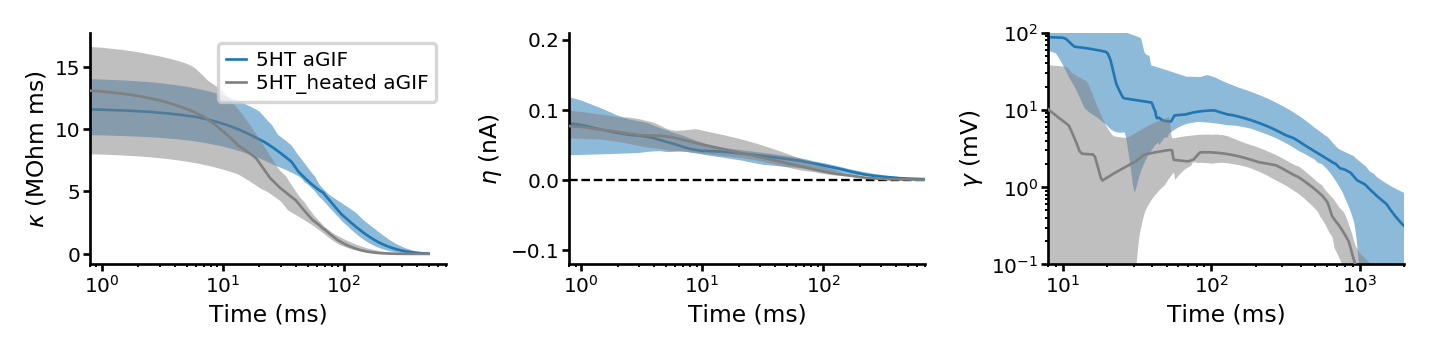

In [8]:
plt.figure(figsize=(6, 1.5))

plt.subplot(131)
for i, (data_name, color_name, model_name, model_type) in enumerate(
    zip(
        ['5HT', '5HT_heated'],
        ['ser', 'pyr'],
        ['aGIF', 'aGIF'],
        ['AugmentedGIFs', 'AugmentedGIFs'],
    )
):
    membrane_filters = [
        mod.getInterpolatedMembraneFilter(500, 0.5)
        for mod in models[data_name][model_type]
    ]
    membrane_filter_array = np.array(membrane_filters)[:, 1, :]
    membrane_time_supp = membrane_filters[0][0]

    nonparametric_filter_plot(
        membrane_time_supp,
        membrane_filter_array,
        color=colors[color_name],
        zorder=i * 2,
        label=' '.join([data_name, model_name]),
    )

plt.gca().set_xscale('log')
plt.xlim(xlims)
plt.xlabel('Time (ms)')
plt.ylabel(r'$\kappa$ (MOhm ms)')
pltools.hide_border('tr')
plt.legend()

plt.subplot(132)
plt.axhline(0, color='k', ls='--', dashes=(10, 10), lw=0.7, zorder=-1)
for i, (data_name, color_name, model_name, model_type) in enumerate(
    zip(
        ['5HT', '5HT_heated'],
        ['ser', 'pyr'],
        ['aGIF', 'aGIF'],
        ['AugmentedGIFs', 'AugmentedGIFs'],
    )
):
    eta_filters = [
        mod.eta.getInterpolatedFilter(0.5)
        for mod in models[data_name][model_type]
    ]
    eta_filter_array = np.array(eta_filters)[:, 1, :]
    eta_time_supp = eta_filters[0][0]

    nonparametric_filter_plot(
        eta_time_supp,
        eta_filter_array,
        color=colors[color_name],
        zorder=i * 2,
        label=' '.join([data_name, model_name]),
    )

plt.gca().set_xscale('log')
plt.xlim(xlims)
plt.ylim(-0.12, 0.21)
plt.xlabel('Time (ms)')
plt.ylabel(r'$\eta$ (nA)')
pltools.hide_border('tr')

gamma_ax = plt.subplot(133)
for i, (data_name, color_name, model_name, model_type) in enumerate(
    zip(
        ['5HT', '5HT_heated'],
        ['ser', 'pyr'],
        ['aGIF', 'aGIF'],
        ['AugmentedGIFs', 'AugmentedGIFs'],
    )
):
    gamma_filters = [
        mod.gamma.getInterpolatedFilter(0.5)
        for mod in models[data_name][model_type]
    ]
    gamma_filter_array = np.array(gamma_filters)[:, 1, :]
    gamma_time_supp = gamma_filters[0][0]

    nonparametric_filter_plot(
        gamma_time_supp,
        gamma_filter_array,
        color=colors[color_name],
        zorder=i * 2,
        ax=gamma_ax,
        label=' '.join([data_name, model_name]),
    )

gamma_ax.set_xscale('log')
gamma_ax.set_yscale('log')
gamma_ax.set_xlim(8, 2000)
gamma_ax.set_ylim(0.1, 1e2)


pltools.hide_border('tr', ax=gamma_ax)

gamma_ax.set_xlabel('Time (ms)')
gamma_ax.set_ylabel(r'$\gamma$ (mV)')

plt.tight_layout()

savefig(
    os.path.join(
        os.getenv('IMG_PATH', 'ser_nonparametric_filter_plot_temp_comparison')
    )
)